In [1]:
import pandas as pd 
import numpy as np 
import sys
sys.path.insert(0, '../make_source_label_hierarchy/')
import os
os.environ['OPENAI_API_KEY']=open('/Users/spangher/.openai-isi-project-key.txt').read().strip()
from utils_client import call_openai_completions

In [2]:
source_df = pd.read_csv('../make_source_label_hierarchy/similarity_training_data/full-source-df-with-clusters.csv')
cluster_centers = np.load('../make_source_label_hierarchy/models/kmeans-embs-output.txt')

In [3]:
source_df['Narrative Function'].drop_duplicates().head(10).tolist()

['"Sponsor": This source is the sponsor of the content and is used to provide information about the project and its goals.',
 '"Authority": This source is used to provide information about the Framingham Heart Study and its findings.',
 '"Authority": This source is used to provide information about the study and its findings.',
 '"Illustrator": This source is used to provide information about the artwork "The Space Within" and its meaning.',
 '"Expert": This source is used to provide information about the future of healthcare and the role of technology in it.',
 '"Expert": This source is used to provide information about the development of nanosensors and their potential applications in healthcare.',
 '"Expert": This source is used to provide information about the development of healthcare technology and its potential applications.',
 '"Authority": This source is used to provide information about the Precision Medicine Initiative and its goals.',
 '"Expert": This source is used to prov

In [4]:
LEAF_NODE_PROMPT = """
You are a helpful assistant. I will give you a large set of labels I wrote down.

Here are the labels:

{labels}

Please summarize them with a single, specific label for the entire group. Be descriptive so I can really understand.
Please return just one label and one description. Make it in the same format as the input labels.
"""

In [109]:
labels = source_df.loc[lambda df: df['clusters'] == 9].sample(50)['Narrative Function']
call_openai_completions(prompt=LEAF_NODE_PROMPT.format(labels='\n'.join(labels)))

'"Public Health Authority": This collective label is assigned to sources that provide credible, expert information and guidance on public health topics, including but not limited to vaccine safety, effectiveness, clinical trials, pandemic response measures, and disease prevention. These sources are often official health organizations, government agencies, or reputable experts in the field of medicine and science, whose statements are widely recognized and trusted.'

In [124]:
from tqdm.auto import tqdm
groups = list(source_df.groupby('clusters')['Narrative Function'])
child_node_summaries = {}
for cluster_id, g in tqdm(groups):
    g = g.dropna()
    label_sample = g.sample(min(len(g), 50))
    summary_label = call_openai_completions(prompt=LEAF_NODE_PROMPT.format(labels='\n'.join(label_sample)))
    child_node_summaries[cluster_id] = summary_label

  0%|          | 0/1024 [00:00<?, ?it/s]

In [169]:
pd.Series(child_node_summaries).to_csv('cache/child-node-summaries.txt', index=False)

# Hierarchical KMeans

In [41]:
from sklearn.cluster import KMeans

In [ ]:
import random
from numpy.random import exponential
from scipy.stats import expon

source_df = pd.read_csv('../make_source_label_hierarchy/similarity_training_data/full-source-df-with-clusters.csv')
cluster_centers = np.load('../make_source_label_hierarchy/models/kmeans-embs-output.txt')
child_node_summaries = pd.read_csv('cache/child-node-summaries.txt')['0']

In [6]:
def decreasing_probability_sampling(n_total, k):
    output = []

    for i in range(1, n_total):
        prob = 1 / (i**k)
        r = random.random()
        
        if r < prob:
            output.append(i)
    
    return output

bins = decreasing_probability_sampling(1024, .9)
bins

[1, 2, 4, 5, 6, 7, 10, 13, 16, 46, 63, 118, 166, 818, 831]

In [148]:
INNER_NODE_PROMPT_KMEANS = """
You are a helpful assistant. I will give you a list of labels I wrote.

Here are the labels:

{labels}

Please condense them into a single, specific label, focusing on their commonalities. 
Focus on the narrative role of the source, less on specific industries or topics they might cover. 
Try to avoid using the word "narrative" unless necessary.
Please return just one 2-3 word label and one description. Make it in the same format as the input labels.
"""

In [234]:
clustering_rounds = {}
intermediate_node_summaries = child_node_summaries
cluster_centers = np.load('../make_source_label_hierarchy/models/kmeans-embs-output.txt')
bins = [1, 3, 6, 15, 40]#, 150]

In [235]:
# inter_summ
# cluster_centers.shape

In [236]:
from tqdm.auto import tqdm

In [237]:
sample_weights = source_df['clusters'].value_counts().sort_index()
use_sample_weights = True
for bin_idx in reversed(bins):
    kmeans = KMeans(bin_idx)
    if use_sample_weights:
        labels = kmeans.fit_predict(cluster_centers, sample_weight=sample_weights)
        sample_weights = (
            sample_weights
                 .to_frame('old_sample_weights').assign(parent_cluster=kmeans.labels_)
                 .reset_index(drop=True)
                 .groupby('parent_cluster')['old_sample_weights'].sum()
        )
    else:
        labels = kmeans.fit_predict(cluster_centers)
    
    inter_summ = (
        pd.Series(intermediate_node_summaries)
            .to_frame('cluster_description')
            .reset_index()
            .rename(columns={'index': 'child_cluster'})
    )
    inter_summ['parent_cluster'] = kmeans.labels_
    clustering_rounds[bin_idx] = inter_summ.copy()
    groups = list(inter_summ.groupby('parent_cluster')['cluster_description'])
    intermediate_node_summaries = {}
    for cluster_id, g in tqdm(groups):
        g = g.dropna()
        label_sample = g.sample(min(len(g), 50))
        summary_label = call_openai_completions(prompt=INNER_NODE_PROMPT_KMEANS.format(labels='\n'.join(label_sample)))
        intermediate_node_summaries[cluster_id] = summary_label

    cluster_centers = kmeans.cluster_centers_

inter_summ = pd.Series(intermediate_node_summaries).to_frame('cluster_description').reset_index().rename(columns={'index': 'child_cluster'})
clustering_rounds[0] = inter_summ.copy()

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [238]:
sorted_keys = sorted(clustering_rounds.keys(), key=lambda x: -x)

## zero_out, for sanity
for c in clustering_rounds.values():
    c['parent_round'] = np.nan
    c['current_round'] = np.nan
    c['child_round'] = np.nan

for child_round, parent_round in zip(sorted_keys[:-1], sorted_keys[1:]):
    child_df = clustering_rounds[child_round]
    child_df['parent_round'] = parent_round
    child_df['current_round'] = child_round
    # 
    parent_df = clustering_rounds[parent_round]
    parent_df['child_round'] = child_round
    parent_df['current_round'] = parent_round

all_clusters = pd.concat(list(map(lambda i: clustering_rounds[i], sorted_keys)))
all_clusters = all_clusters.rename(columns={
    'child_cluster': 'node_idx',
    'cluster_description': 'node_description',
    'parent_cluster': 'parent_idx',
    'parent_round': 'parent_tree_level',
    'current_round': 'node_tree_level',
    'child_round': 'child_tree_level'
}) #.loc[lambda df: df['parent_round'].isnull()]

In [241]:
import utils_tree as ut
from collections import defaultdict
def build_parent_lists():
    parent_lists = []
    leaf_nodes = all_clusters.loc[lambda df: df['child_tree_level'].isnull()]
    for node_id, row in tqdm(leaf_nodes.iterrows(), total=len(leaf_nodes)):
        running_list = []
        running_list.append(row['node_description'])
        while True:
            row = (all_clusters
                       .loc[lambda df: df['node_tree_level'] == row['parent_tree_level']]
                       .loc[row['parent_idx']]
                  )
            running_list.append(row['node_description'])
            if pd.isnull(row['parent_tree_level']):
                break
        parent_lists.append(running_list)
    return parent_lists

def build_rooted_tree(text_processing_function=None):
    tree = {}
    # all_clusters.loc[lambda df: df['parent_tree_level'].isnull()].iloc[0]
    old_parent_children = defaultdict(list)
    curr_parent_children = defaultdict(list)
    curr_nodes = all_clusters.loc[lambda df: df['child_tree_level'].isnull()]
    while True:
        for node_id, row in curr_nodes.iterrows():
            p_idx = row['parent_idx'] if pd.notnull(row['parent_idx']) else 'root'
            node_desc = row['node_description'] if text_processing_function is None else text_processing_function(row['node_description'])
            curr_parent_children[p_idx].append({
                "node": node_desc,
                "children": old_parent_children.get(row['node_idx'])
            })
        old_parent_children = curr_parent_children
        curr_parent_children = defaultdict(list)
        if curr_nodes['parent_tree_level'].isnull().any():
            break
        curr_nodes = all_clusters.loc[lambda df: df['node_tree_level'] == row['parent_tree_level']]
    return old_parent_children['root'][0]

In [242]:
t = build_rooted_tree(text_processing_function=lambda x: x.split(':')[0].split('\n\n')[0])

In [243]:
import networkx as nx

def build_networkx_graph(d, G=None, parent=None, depth=0):
    if G is None:
        G = nx.DiGraph()  # You can use nx.Graph() if the graph is undirected

    node_label = f"{d.get('node')}-{depth}"
    if node_label is None:
        return G  # If there's no node, nothing to add

    # Add the node with the 'description' attribute
    G.add_node(node_label, description=node_label)

    if parent is not None:
        # Add an edge from the parent to this node
        G.add_edge(parent, node_label)

    children = d.get('children', [])
    if children:
        for child in children:
            if child:  # Ensure child is not None
                build_networkx_graph(child, G, parent=node_label, depth=depth+1)

    return G

In [244]:
G = build_networkx_graph(t)

In [249]:
from adjustText import adjust_text

In [254]:
# Specify the desired depth
desired_depth = 4  # Change this to your desired depth
# Compute the shortest path lengths from the root node to all other nodes
depths = nx.single_source_shortest_path_length(G, f"{t['node']}-{0}")
nodes_within_depth = [node for node, depth in depths.items() if depth <= desired_depth]
G_sub = G.subgraph(nodes_within_depth)

In [269]:
import re 

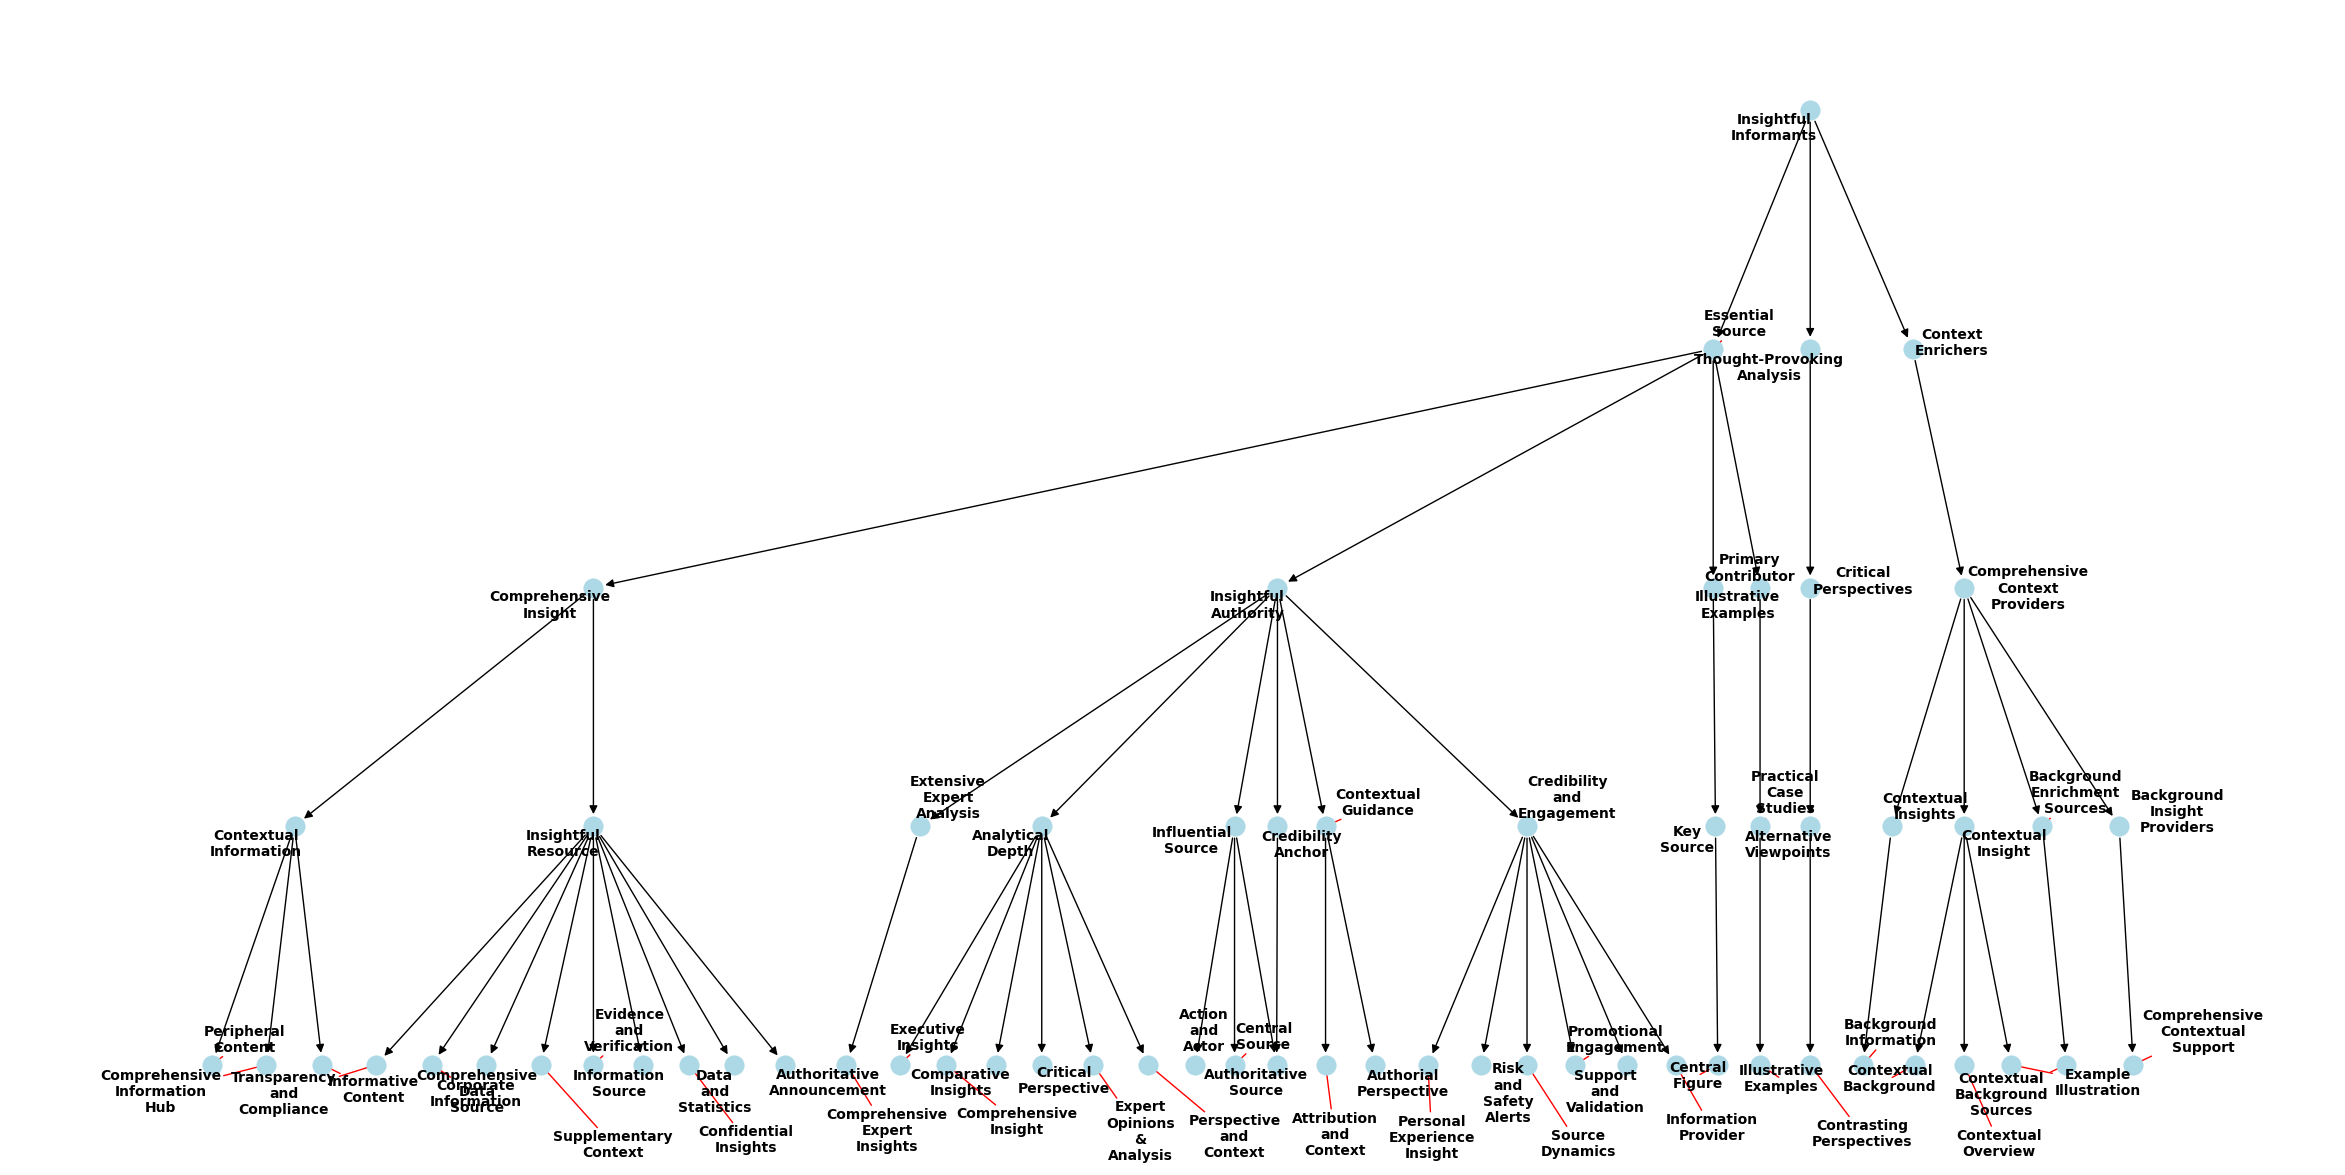

In [285]:
plt.figure(figsize=(30, 15))

# Compute the positions for the nodes using hierarchy_pos
pos = nx.drawing.nx_agraph.graphviz_layout(G_sub, prog="dot")

nx.draw_networkx_edges(G_sub, pos, arrows=True, arrowstyle='-|>', arrowsize=12)
nx.draw_networkx_nodes(G_sub, pos, node_size=200, node_color='lightblue', linewidths=0.25)

# Prepare the texts for adjustment
labels = nx.get_node_attributes(G_sub, 'description')
texts = []
for node, (x, y) in pos.items():
    text = plt.text(x, y, re.split(r'-\d', labels[node])[0].replace(' ', '\n').replace('"', ''), fontsize=10, fontweight='bold', ha='center', va='center')
    texts.append(text)

# Adjust the texts to minimize overlaps
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='red', ))

# Draw the tree
# nx.draw(G_sub, pos, with_labels=True, node_size=70, node_color="skyblue", font_size=6)
plt.axis('off')
plt.show()

In [271]:
l = build_parent_lists()

  0%|          | 0/1024 [00:00<?, ?it/s]

In [272]:
list(reversed(l[10]))

['"Insightful Informants": These sources collectively offer crucial insights, context, and analysis, enriching the reader\'s understanding and engagement through diverse perspectives and enhancing the depth and accuracy of information presented.',
 '"Essential Source": This label encapsulates individuals, companies, or entities that play a pivotal role in providing key information, expert insights, illustrative examples, and comprehensive analysis, crucial for enhancing reader understanding, ensuring accurate reporting, and guiding audience comprehension across various subjects.',
 '"Comprehensive Insight": These sources offer crucial information, context, and credible analysis across various subjects, which aid in enhancing readers\' understanding and ensuring thorough and accurate reporting.',
 '"Insightful Resource": These sources collectively provide essential data, context, analysis, and credibility across diverse topics, enhancing depth and understanding in journalistic articles 

In [273]:
l[1]

['"Disclaimer": This source is used to provide legal disclaimers, trademark information, and notices on ownership and usage terms of trademarks and content associated with the article.',
 '"Transparency and Compliance": This collection of sources is used to provide essential disclaimers and disclosures that ensure transparency, clarify legal responsibilities, and inform users about data usage, affiliations, funding, content rights, and organizational policies, promoting ethical standards and compliance.',
 '"Insightful Resource": These sources collectively provide essential data, context, analysis, and credibility across diverse topics, enhancing depth and understanding in journalistic articles and ensuring comprehensive and accurate reporting.',
 '"Comprehensive Insight": These sources offer crucial information, context, and credible analysis across various subjects, which aid in enhancing readers\' understanding and ensuring thorough and accurate reporting.',
 '"Essential Source": Th

# Associate clusters with Sources

In [274]:
bins=list(clustering_rounds.keys())
bins

[40, 15, 6, 3, 1, 0]

In [275]:
for k in clustering_rounds:
    clustering_rounds[k]
    break

In [276]:
clustering_rounds[k]

,child_cluster,cluster_description,parent_cluster,parent_round,current_round,child_round
0,0,"""Counterpoint"": This collection of sources is ...",0,15,40,NaN
1,1,"""Disclaimer"": This source is used to provide l...",19,15,40,NaN
2,2,"""Main Actor"": This source is the principal foc...",7,15,40,NaN
3,3,"""Authority"": This source is used to provide ex...",24,15,40,NaN
4,4,"""Main Actor"": This source is the central figur...",7,15,40,NaN
...,...,...,...,...,...,...
1019,1019,"""Counterpoint"": This group of sources is used ...",0,15,40,NaN
1020,1020,"""Support and Advocacy"": This group of sources ...",29,15,40,NaN
1021,1021,"""Contrasting Example"": These sources are used ...",0,15,40,NaN
1022,1022,"""Predictive Analysis Source"": This consolidate...",11,15,40,NaN


In [277]:
bins

[40, 15, 6, 3, 1, 0]

In [278]:
source_df_with_clusters = (
    source_df
         .loc[lambda df: df['Is_Error'] == False]
         .drop(columns=['Is_Error', 'Unnamed: 0'])
         .merge(clustering_rounds[bins[0]][['child_cluster', 'cluster_description', 'parent_cluster']], right_on='child_cluster', left_on='clusters')
         .drop(columns=['child_cluster', 'clusters']).rename(columns={'cluster_description': 'cluster_descript_leaf_1'})
         .merge(clustering_rounds[bins[1]][['child_cluster', 'cluster_description', 'parent_cluster']], right_on='child_cluster', left_on='parent_cluster')
         .drop(columns=['child_cluster', 'parent_cluster_x']).rename(columns={'cluster_description': 'cluster_descript_leaf_2', 'parent_cluster_y': 'parent_cluster'})
         .merge(clustering_rounds[bins[2]][['child_cluster', 'cluster_description', 'parent_cluster']], right_on='child_cluster', left_on='parent_cluster')
         .drop(columns=['child_cluster', 'parent_cluster_x']).rename(columns={'cluster_description': 'cluster_descript_leaf_3', 'parent_cluster_y': 'parent_cluster'})
         .merge(clustering_rounds[bins[3]][['child_cluster', 'cluster_description', 'parent_cluster']], right_on='child_cluster', left_on='parent_cluster')
         .drop(columns=['child_cluster', 'parent_cluster_x']).rename(columns={'cluster_description': 'cluster_descript_leaf_4', 'parent_cluster_y': 'parent_cluster'}) 
         .merge(clustering_rounds[bins[4]][['child_cluster', 'cluster_description', 'parent_cluster']], right_on='child_cluster', left_on='parent_cluster')
         .drop(columns=['child_cluster', 'parent_cluster_x']).rename(columns={'cluster_description': 'cluster_descript_leaf_5', 'parent_cluster_y': 'parent_cluster'}) 
         .drop(columns=['parent_cluster'])
)

In [279]:
source_df_with_clusters['cluster_descript_leaf_1'].str.split(':').str.get(0).str.split('\n\n').str.get(0).value_counts()

cluster_descript_leaf_1
"Context"                                       20917
"Main Actor"                                    17606
"Counterpoint"                                  17239
"Expert Opinion"                                13660
"Context Provider"                               9324
                                                ...  
"National Day Promotion Participant"               61
"Weather Forecasts and Reports"                    59
"Interest Point Category"                          59
"Veterans Day Offers and Holiday Promotions"       54
"Problem Illustration"                             54
Name: count, Length: 607, dtype: int64

In [280]:
source_df_with_clusters['cluster_descript_leaf_2'].str.split(':').str.get(0).str.split('\n\n').str.get(0).str.strip().value_counts()

cluster_descript_leaf_2
"Contrasting Perspectives"            31256
"Authoritative Source"                21696
"Background Information"              21633
"Central Figure"                      20324
"Comprehensive Expert Insights"       18821
"Central Source"                      17139
"Comprehensive Insight"               16957
"Illustrative Examples"               15846
"Comprehensive Contextual Support"    14821
"Expert Opinions & Analysis"          14175
"Contextual Overview"                 13225
"Informative Content"                 12846
"Information Source"                  11259
"Contextual Background Sources"       11107
"Confidential Insights"               10974
"Source Dynamics"                     10400
"Comprehensive Data Source"           10152
"Example Illustration"                 9451
"Support and Validation"               9404
"Corporate Information"                9121
"Data and Statistics"                  9014
"Evidence and Verification"            8990
"Attribu

In [281]:
source_df_with_clusters['cluster_descript_leaf_3'].str.split(':').str.get(0).str.split('\n\n').str.get(0).str.strip().value_counts()

cluster_descript_leaf_3
"Insightful Resource"              73033
"Analytical Depth"                 54343
"Credibility and Engagement"       41982
"Influential Source"               34613
"Alternative Viewpoints"           31256
"Contextual Insight"               30377
"Contextual Information"           21941
"Contextual Insights"              21633
"Key Source"                       20324
"Extensive Expert Analysis"        18821
"Contextual Guidance"              17135
"Practical Case Studies"           15846
"Background Insight Providers"     14821
"Background Enrichment Sources"    11107
"Credibility Anchor"                9071
Name: count, dtype: int64

In [282]:
source_df_with_clusters['cluster_descript_leaf_4'].str.split(':').str.get(0).str.split('\n\n').str.get(0).str.strip().value_counts()

cluster_descript_leaf_4
"Insightful Authority"               175965
"Comprehensive Insight"               94974
"Comprehensive Context Providers"     77938
"Critical Perspectives"               31256
"Primary Contributor"                 20324
"Illustrative Examples"               15846
Name: count, dtype: int64

In [283]:
source_df_with_clusters['cluster_descript_leaf_5'].str.split(':').str.get(0).str.split('\n\n').str.get(0).str.strip().value_counts()

cluster_descript_leaf_5
"Essential Source"              307109
"Context Enrichers"              77938
"Thought-Provoking Analysis"     31256
Name: count, dtype: int64

In [284]:
source_df_with_clusters.to_csv('cache/2024-09-19__source-df-with-all-clusters.csv')

# Agglomerative Hierarchical Clustering

In [325]:
import numpy as np
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='single')#, metric='cosine')
model.fit(cluster_centers)

AgglomerativeClustering(distance_threshold=0, linkage='single', n_clusters=None)

In [326]:
# children_array-like of shape (n_samples-1, 2)
#     The children of each non-leaf node. 
#     Values less than n_samples correspond to leaves of the tree which are the original samples. 
#     A node i greater than or equal to n_samples is a non-leaf node and has children children_[i - n_samples]. 
#     Alternatively at the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i.

# distances_array-like of shape (n_nodes-1,)
#     Distances between nodes in the corresponding place in children_. 
#     Only computed if distance_threshold is used or compute_distances is set to True.

In [327]:
# Build counts and linkage_matrix
counts = np.zeros(model.children_.shape[0])
n_samples = len(model.labels_)
for i, merge in enumerate(model.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

# Initialize dictionaries
node_samples = {}
node_summaries = {}

In [328]:
# Get node IDs and their corresponding heights (distances)
node_ids = range(n_samples, linkage_matrix.shape[0] + n_samples)
heights = linkage_matrix[:, 2]  # distances
node_heights = list(zip(node_ids, heights))

# Sort nodes by their heights (from lowest to highest)
node_heights_sorted = sorted(node_heights, key=lambda x: x[1])

In [329]:
INNER_NODE_PROMPT = """
You are a helpful assistant. I will give you a two labels I wrote.

Here are the labels:

{labels}

Please condense them into a single, specific label, focusing on their commonalities. 
Be as concise as possible! Avoid words like "Extensive", "Comprehensive", and "Holistic". 
Focus on the narrative role of the source, less on specific industries or topics they might cover.
Please return just one 2-3 word label and one description. Make it in the same format as the input labels.
"""

In [330]:
# Loop over all non-leaf nodes from the lowest upwards
for node_id, _ in tqdm(node_heights_sorted):
    children = get_immediate_children(node_id)
    labels = []
    for child_id in children:
        if child_id < n_samples:
            label = child_node_summaries[child_id]
        else:
            label = node_summaries[child_id]
        labels.append(label)
    labels_str = '\n'.join(labels)
    prompt = INNER_NODE_PROMPT.format(labels=labels_str)
    output = call_openai_completions(prompt=prompt)
    node_summaries[node_id] = output

  0%|          | 0/1023 [00:00<?, ?it/s]

In [331]:
def print_tree(node_id, level=0, max_nodes=None, nodes_printed=[0]):
    if max_nodes is not None and nodes_printed[0] >= max_nodes:
        return
    indent = '    ' * level
    summary = node_summaries.get(node_id, "No summary available")
    print(f"{indent}- Node {node_id}: {summary}")
    nodes_printed[0] += 1
    if node_id < n_samples:
        # Leaf node; no further traversal
        return
    # Get immediate children
    children = get_immediate_children(node_id)
    for child_id in children:
        if max_nodes is not None and nodes_printed[0] >= max_nodes:
            return
        print_tree(child_id, level + 1, max_nodes, nodes_printed)

# Number of nodes to print
k = 10  # You can set k to any integer value you prefer
# Start from the root node (the last node formed in the clustering)
root_node_id = 2 * n_samples - 2  # This is the ID of the root node

# Call the function to print the tree
print_tree(root_node_id, max_nodes=k)

- Node 2046: Label: "Critical Analysis"

Description: Provides context and depth to enhance understanding.
    - Node 2045: Label: "Comparative Insights"

Description: Offers critical analysis and context to enhance the article's depth and understanding.
        - Node 2044: Label: "Informed Perspectives"

Description: Provides comparative insights and critical analysis to deepen the article's context and understanding.
            - Node 2043: Label: "Contextual Comparisons"

Description: Highlights diverse viewpoints and underlying factors to enrich understanding and context within the article.
                - Node 1576: Label: "Balanced Perspectives"

Description: Sources providing varied views to enhance understanding through balanced comparisons or contrasting points.
                    - Node 1573: Label: "Diverse Views"

Description: Sources providing varied perspectives to enhance understanding through balanced comparisons or contrasting points.
                        - Nod

In [335]:
# Set the desired depth level to collect nodes
k = 12  # Change this to your desired depth level

# Identify the root node ID and collect all nodes at depth k
root_node_id = 2 * n_samples - 2  # Root node ID for hierarchical clustering
nodes_at_depth_k = collect_nodes_at_depth_k(root_node_id, target_level=k)

# Now, print the summaries of all nodes at depth k
print('-------------------------------------------')
print(f'Nodes and depth: {k}')
print('-------------------------------------------')
print()
for node_id in nodes_at_depth_k:
    summary = node_summaries.get(node_id, "No summary available")
    # print(f"Node {node_id}: {summary[:200]}...")
    print(f"Node {node_id}: {summary}")
    print()

-------------------------------------------
Nodes and depth: 12
-------------------------------------------

Node 1464: Label: "Comparative Analysis"

Description: Sources offering multiple perspectives to highlight controversies and provide balanced understanding through comparisons.

Node 365: No summary available

Node 76: No summary available

Node 89: No summary available

Node 2034: **Label: Guidance Sources**

**Description: Narratives and data highlighting inspirations, ethical considerations, job markets, career opportunities, and expertise from recognized authorities.**

Node 1628: "Key Narrative Source": This source provides pivotal details and updates that shape the storyline, representing essential entities and their actions or promotional offerings on social issues and special events.

Node 1320: "Context Source": These sources provide background information and broader connections that enhance understanding and situate content within a broader framework.

Node 1082: "COV

In [306]:
# Build the parent mapping
parent_dict = build_parent_dict()

In [307]:
# Choose a leaf node ID to trace (must be less than n_samples)
leaf_node_id = 100  # Replace this with the actual leaf node ID you want to trace

# Trace the path from the leaf node to the root
path = trace_leaf_to_root(leaf_node_id, parent_dict)

# Optionally, print the summaries along the path
print('-------------------------------------------')
print(f"Tracing from leaf node {leaf_node_id} to root:")
print('-------------------------------------------')
print()

for node_id in path:
    if node_id < n_samples:
        # Leaf node; get the original text from the DataFrame
        summary = source_df.iloc[node_id]['Narrative Function']
    else:
        # Non-leaf node; get the summary from node_summaries
        summary = node_summaries.get(node_id, "No summary available")
    print(f"Node {node_id}: {summary}")
    print('       |')
    print('       v')
    print()

-------------------------------------------
Tracing from leaf node 100 to root:
-------------------------------------------

Node 100: "Primary Source": This source is used to provide primary information about the company's compensation packages, financial data, and business decisions.
       |
       v

Node 1833: "Initiatives and Innovations": This collective group of labels thoroughly documents an array of proposals, strategic goals, innovative advancements, and development efforts spanning various sectors such as technology, healthcare, labor, economy, environment, and governance. It encompasses the introduction of new initiatives and strategic objectives, as well as highlighting forward-thinking and creative solutions, significant progress, new corporate appointments, product innovations, policy changes, and future plans across multiple industries.
       |
       v

Node 1927: "Innovations and Transitions Summary Label: This source covers topics related to the introduction of new